# Importing necessary Libraries

In [40]:
import warnings
warnings.filterwarnings("ignore")

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout,Conv2D,Flatten,MaxPool2D,Reshape,InputLayer
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Data Augumentation

* Dataset consist of 5 classes.
* **Daisy** - European Species of Aster family.
* **Sunflower** - Identified as the genus of Helianthus.
* **Tulip** - Belong to the species of spring blooming geophytes.
* **Rose** - Belongs to the family of rosaceae.
* **Dandelion** - Indentifies as the genus of Asterceae.

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
path = '/content/drive/MyDrive/IBM/Flowers'

In [44]:
train_data_gen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True,
                             validation_split = 0.30)
test_data_gen = ImageDataGenerator(rescale = 1./255,validation_split = 0.30)

In [45]:
training_set = train_data_gen.flow_from_directory(path,
                                                 target_size=(64,64),
                                                 batch_size=100,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 color_mode='rgb',
                                                 subset = 'training')

testing_set = test_data_gen.flow_from_directory(path,
                                                 target_size=(64,64),
                                                 batch_size=100,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 color_mode='rgb',
                                                 subset = 'validation')

Found 3024 images belonging to 5 classes.
Found 1293 images belonging to 5 classes.


# Model building using CNN
**1. Create the model**

In [46]:
model = Sequential()

#convolution and Pooling layer 1
model.add(Conv2D(filters=48,kernel_size=3,activation='relu',input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size=2,strides=2))
model.add(Dropout(0.2))

#convolution and Pooling layer 2
model.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))
model.add(Dropout(0.2))

#Flattening the images
model.add(Flatten())

#Fully Connected layers
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5,activation='softmax'))

In [47]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 48)        1344      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 48)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 31, 31, 48)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 32)        13856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 14, 14, 32)       

**2. Compile the Model**

In [48]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

**3. Adding callbacks to avoid overfitting**

In [49]:
early_stop = EarlyStopping(monitor='val_accuracy', 
                           patience=5,verbose=1,mode='auto')

lr = ReduceLROnPlateau(monitor='val_accuracy', 
                       factor=0.2,patience=5, 
                       min_lr=0.00001)

callback = [early_stop,lr]

**4. Training the Model**

In [50]:
result = model.fit(x=training_set, validation_data=testing_set, epochs=50)

Epoch 1/50
31/31 [==============================] - 34s 1s/step - loss: 1.4530 - accuracy: 0.3356 - val_loss: 1.2834 - val_accuracy: 0.4346
Epoch 2/50
31/31 [==============================] - 34s 1s/step - loss: 1.2313 - accuracy: 0.4778 - val_loss: 1.2067 - val_accuracy: 0.4888
Epoch 3/50
31/31 [==============================] - 32s 1s/step - loss: 1.1542 - accuracy: 0.5205 - val_loss: 1.1497 - val_accuracy: 0.5298
Epoch 4/50
31/31 [==============================] - 32s 1s/step - loss: 1.0865 - accuracy: 0.5562 - val_loss: 1.1172 - val_accuracy: 0.5383
Epoch 5/50
31/31 [==============================] - 34s 1s/step - loss: 1.0444 - accuracy: 0.5837 - val_loss: 1.0959 - val_accuracy: 0.5630
Epoch 6/50
31/31 [==============================] - 32s 1s/step - loss: 1.0181 - accuracy: 0.5995 - val_loss: 1.0392 - val_accuracy: 0.5940
Epoch 7/50
31/31 [==============================] - 32s 1s/step - loss: 0.9764 - accuracy: 0.6114 - val_loss: 1.0642 - val_accuracy: 0.5901
Epoch 8/50
31/31 [==

**5. Loss and Accuracy check using plot**

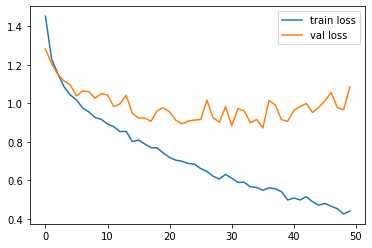

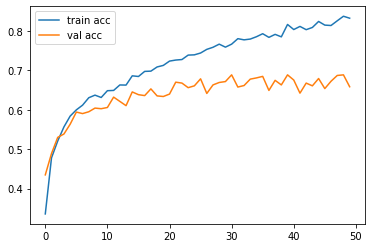

In [51]:
#plot the loss
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(result.history['accuracy'], label='train acc')
plt.plot(result.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

**6. Save the Model**

In [52]:
model.save('flower.h5')

# Testing the Model

In [53]:
training_set.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [54]:
classes = ['Daisy','Dandelion','Rose','Sunflower','Tulip'] 
def testing(img):
    img = image.load_img(img,target_size=(64,64)) 
    x = image.img_to_array(img) 
    x = np.expand_dims(x,axis=0) 
    pred = np.argmax(model.predict(x)) 
    return print("Predicted class as:",classes[pred])

def img_show(img):
    img1 = image.load_img(img,target_size=(64,64)) 
    plt.imshow(img1)

Predicted class as: Daisy


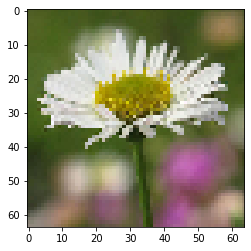

In [58]:
#test1
img_show('/content/drive/MyDrive/IBM/Flowers/daisy/flower1.jpg')
testing('/content/drive/MyDrive/IBM/Flowers/daisy/flower1.jpg')

Predicted class as: Rose


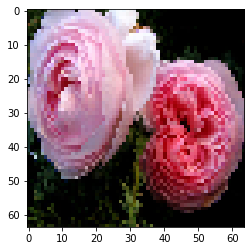

In [59]:
#test2
img_show('/content/drive/MyDrive/IBM/Flowers/rose/flower2.jpg')
testing('/content/drive/MyDrive/IBM/Flowers/rose/flower2.jpg')

Predicted class as: Sunflower


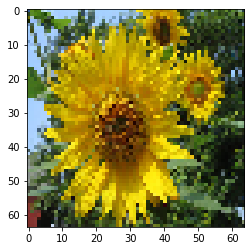

In [60]:
#test3
img_show('/content/drive/MyDrive/IBM/Flowers/sunflower/flower3.jpg')
testing('/content/drive/MyDrive/IBM/Flowers/sunflower/flower3.jpg')

Predicted class as: Tulip


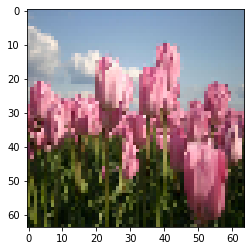

In [62]:
#test4
img_show('/content/drive/MyDrive/IBM/Flowers/tulip/flower4.jpg')
testing('/content/drive/MyDrive/IBM/Flowers/tulip/flower4.jpg')

Predicted class as: Dandelion


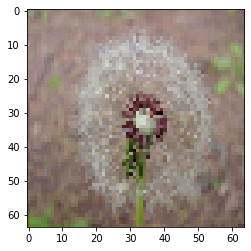

In [66]:
#test5
img_show('/content/drive/MyDrive/IBM/Flowers/dandelion/1.jpg')
testing('/content/drive/MyDrive/IBM/Flowers/dandelion/1.jpg')

# Conclusion:
* The dataset has about 4317 images from 5 different classes.
* Each classes have more than 500 images for training the data.
* 30% of the data taken for validation.
* The accuracy of the model is around 80%.
* The validation accuracy is around 70%.
* The model is built with 2 layered convolutional network considering 1344 trainable parameters.
* Testing the model with unknown images gives 95% accuracy.